# Final Project

## 4/20/2025

- Team Members
    - Brittney Bedrossian
    - Breenda Shah
    - Jeb Besecker
    - Kevin Dennin
    - Kohry Long

### This serves as an initial exploration and data pre processing module. 

# Imports 

In [303]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as mno
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import graphviz
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import export_graphviz
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Changelog Intialization

In [304]:
# Initilize changelog
changelog = []

# Data Load

In [305]:
# Load the dataset
df = pd.read_csv("../Data/loan_data.csv")
df.head()


,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22,female,Master,71948,0,RENT,35000,PERSONAL,16.02,0.49,3,561,No,1
1,21,female,High School,12282,0,OWN,1000,EDUCATION,11.14,0.08,2,504,Yes,0
2,25,female,High School,12438,3,MORTGAGE,5500,MEDICAL,12.87,0.44,3,635,No,1
3,23,female,Bachelor,79753,0,RENT,35000,MEDICAL,15.23,0.44,2,675,No,1
4,24,male,Master,66135,1,RENT,35000,MEDICAL,14.27,0.53,4,586,No,1


In [306]:

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  int64  
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  int64  
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  int64  
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  int64  
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

In [307]:
df.describe()


,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status
count,45000.000000,4.500000e+04,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000
mean,27.764178,8.031905e+04,5.410333,9583.157556,11.006606,0.139725,5.867489,632.608756,0.222222
std,6.045108,8.042250e+04,6.063532,6314.886691,2.978808,0.087212,3.879702,50.435865,0.415744
min,20.000000,8.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,390.000000,0.000000
25%,24.000000,4.720400e+04,1.000000,5000.000000,8.590000,0.070000,3.000000,601.000000,0.000000
50%,26.000000,6.704800e+04,4.000000,8000.000000,11.010000,0.120000,4.000000,640.000000,0.000000
75%,30.000000,9.578925e+04,8.000000,12237.250000,12.990000,0.190000,8.000000,670.000000,0.000000
max,144.000000,7.200766e+06,125.000000,35000.000000,20.000000,0.660000,30.000000,850.000000,1.000000


<Axes: >

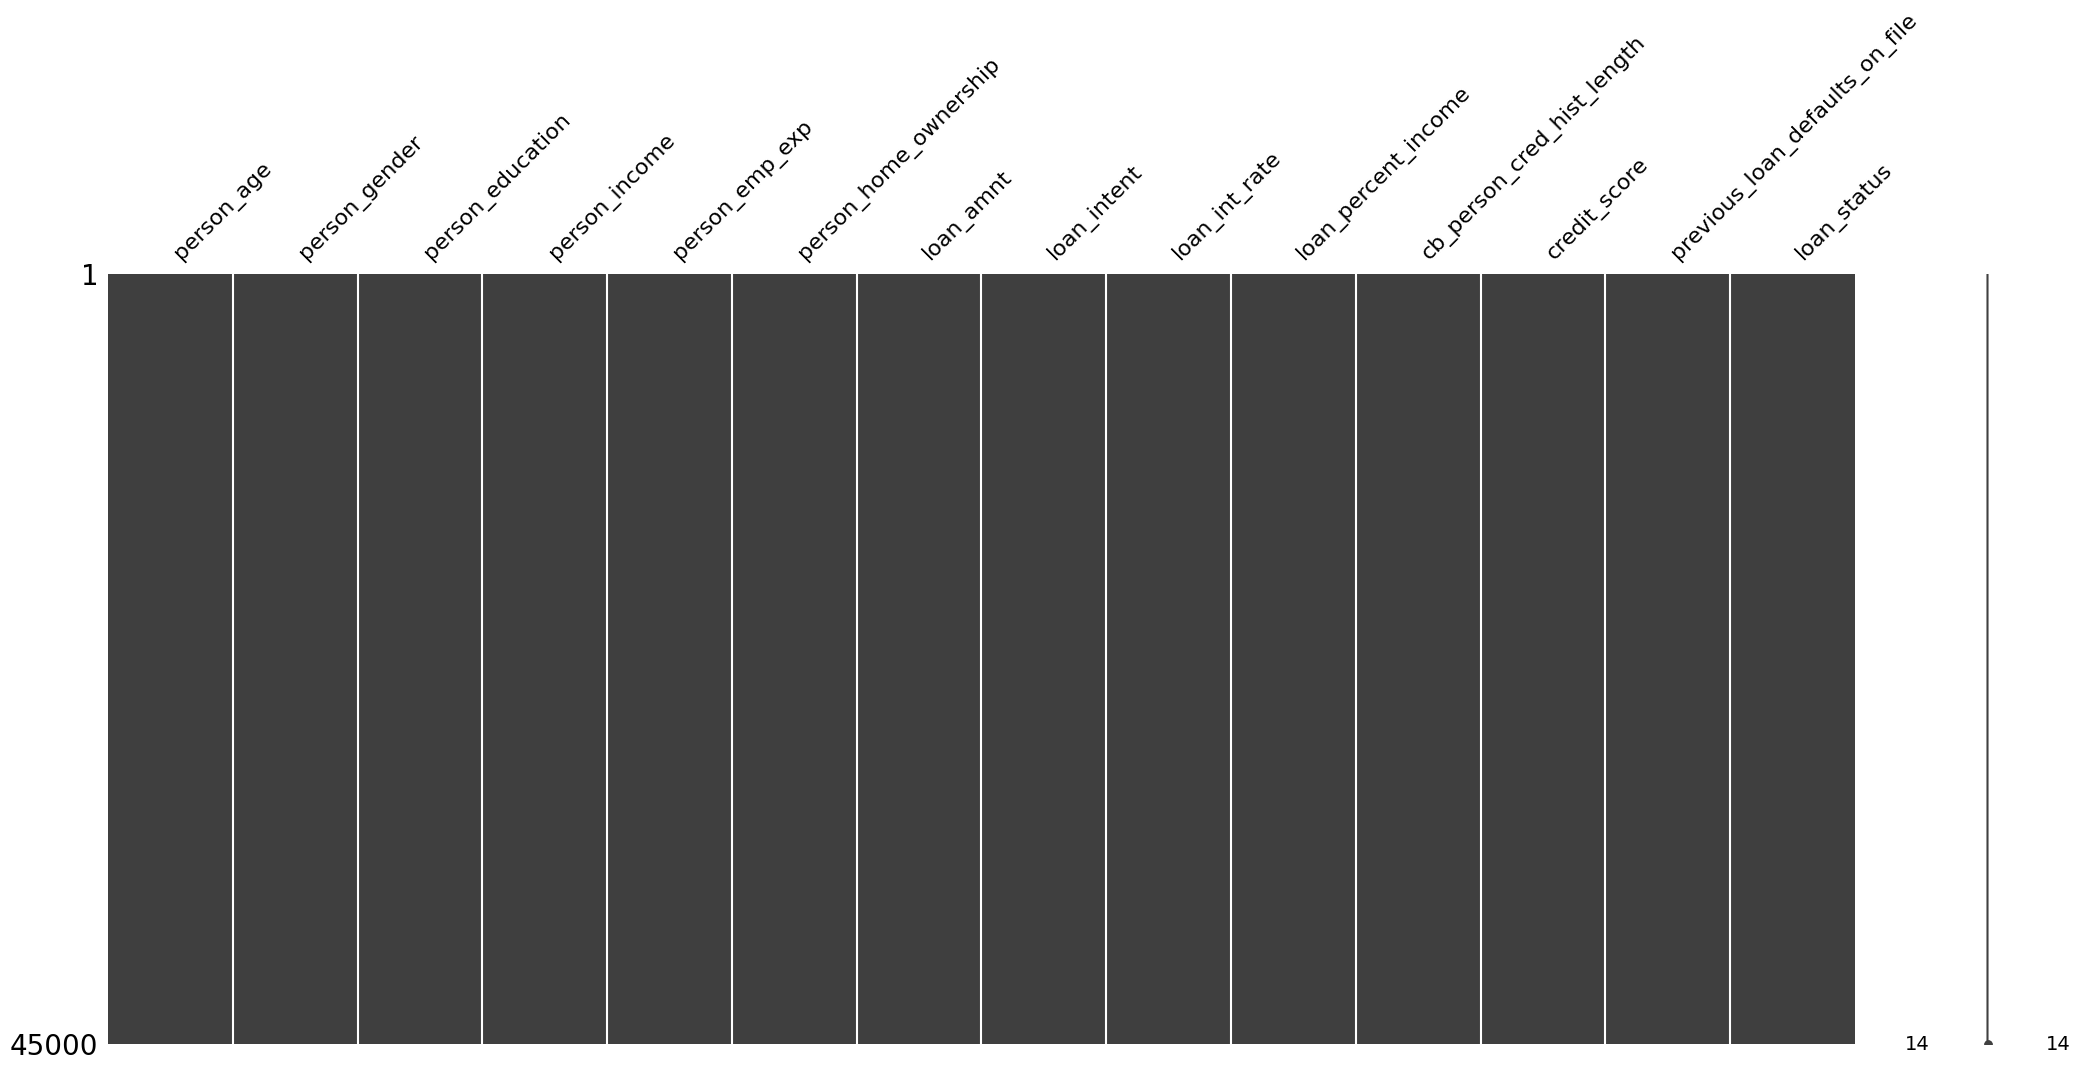

In [308]:
# Explore MissingNo
mno.matrix(df)

# Data Exploration and Categorical Analysis

In [309]:
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
print("Categorical columns:", categorical_columns)

Categorical columns: ['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file']


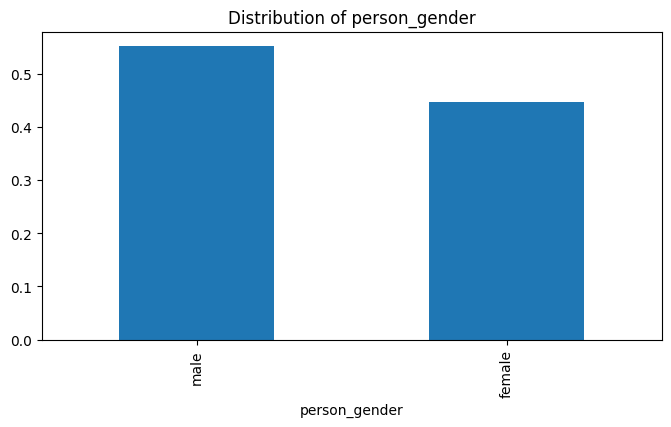

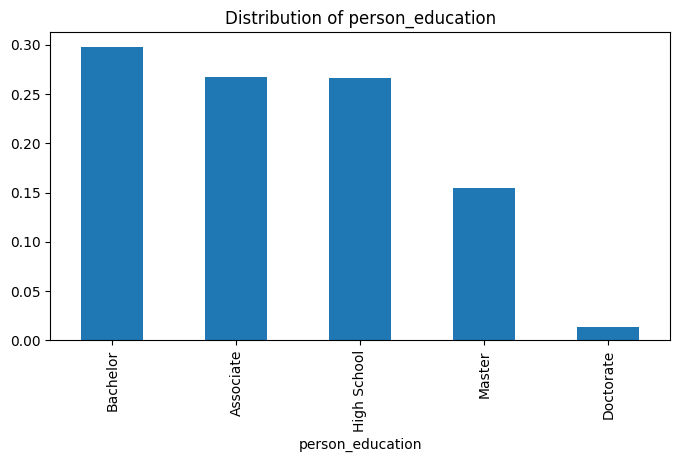

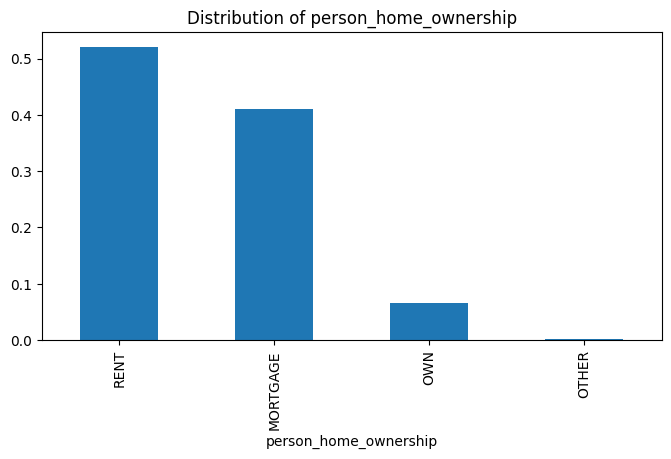

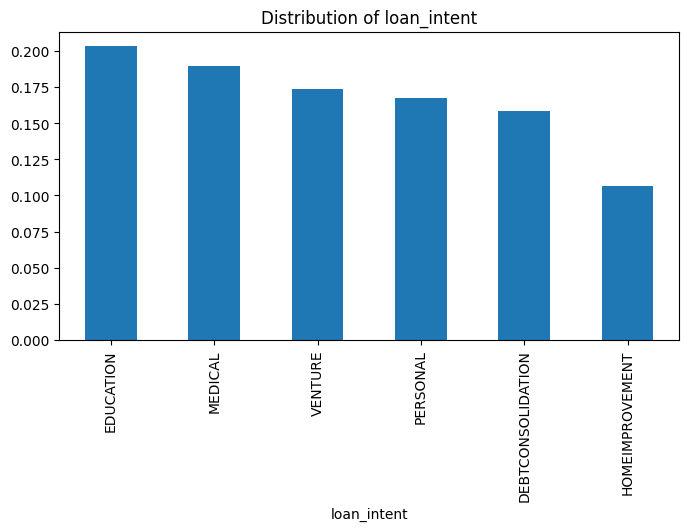

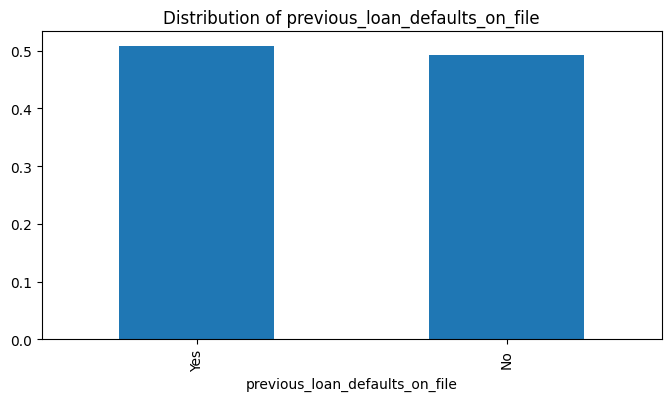

In [310]:
# Univariate analysis of categorical variables
for col in categorical_columns:
    fig = plt.figure(figsize=(8, 4))
    df[col].value_counts(normalize=True).plot(kind='bar')
    plt.title(f"Distribution of {col}")
    plt.show()

# Notes on Categorical Analysis:
- No spelling mistakes
- Person Home ownership needs to be grouped on owned or other. Or other removed entirely
- Overall spread of other categorical variables solid. One exception, person_education (Doctorate small subgroup)

# Numerical Analysis

Numerical columns: ['person_age', 'person_income', 'person_emp_exp', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score', 'loan_status']


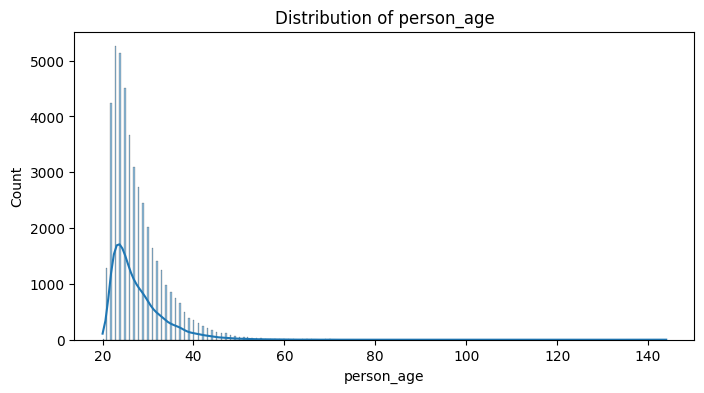

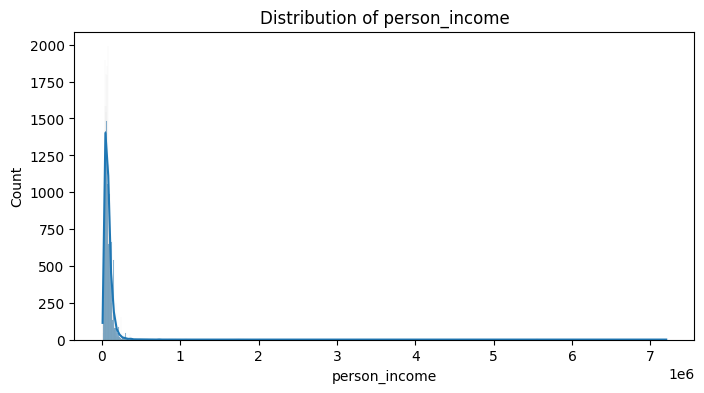

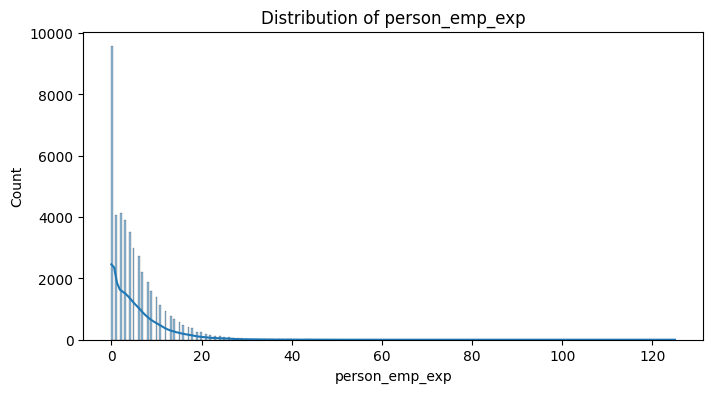

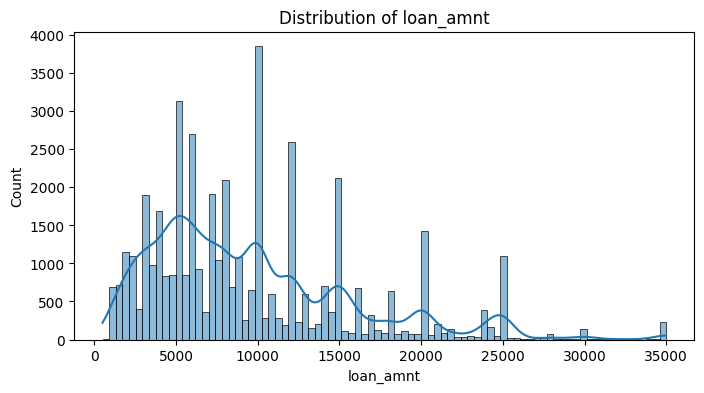

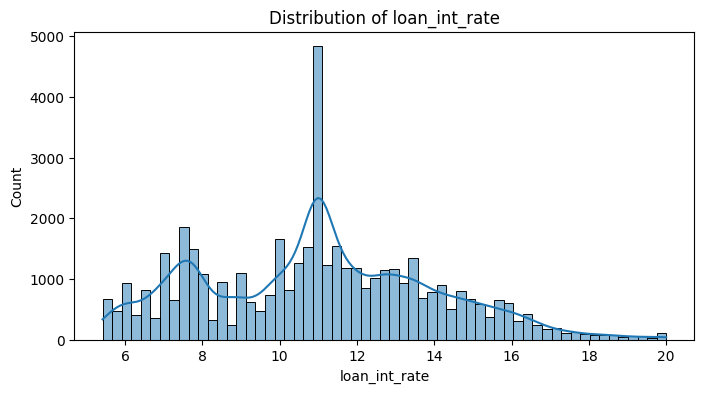

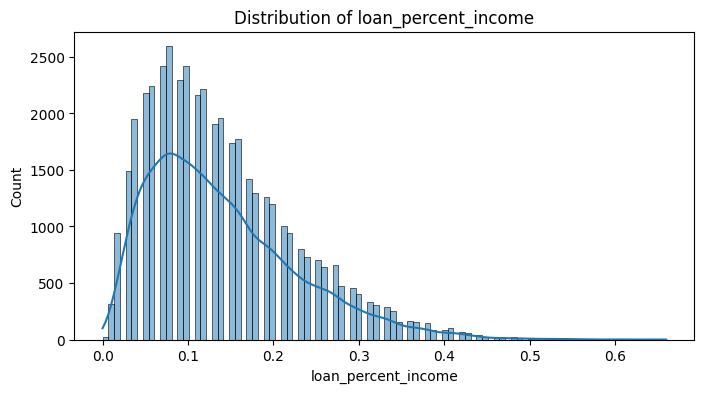

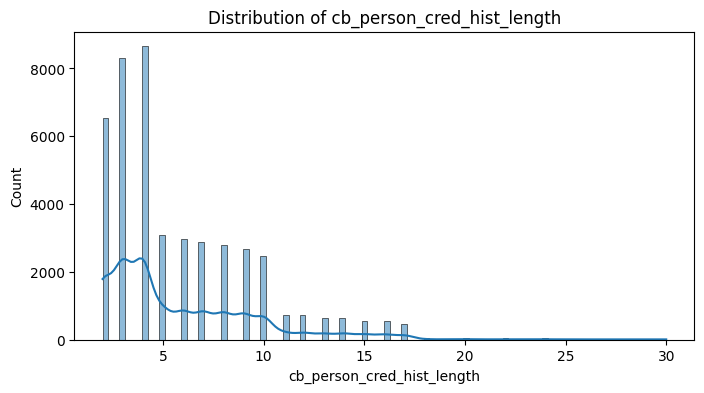

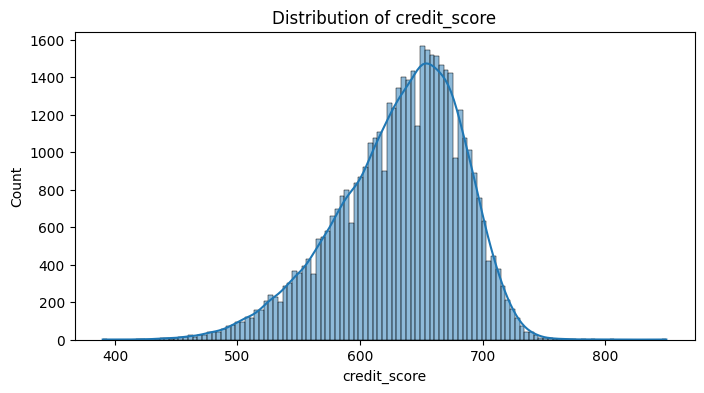

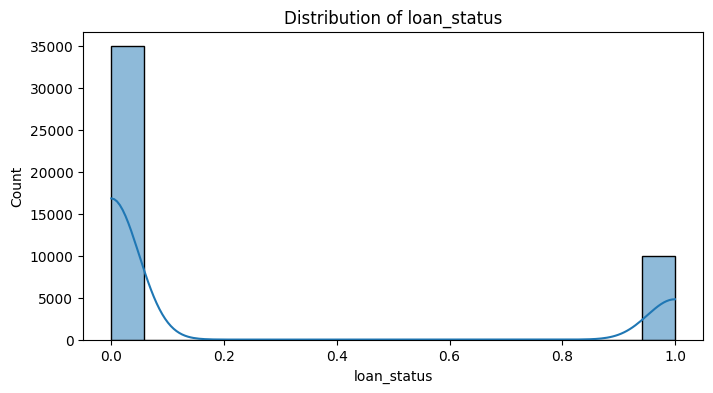

In [311]:
# Univariate analysis of numerical variables
numerical_columns = df.select_dtypes(include=[np.number]).columns.tolist()
print("Numerical columns:", numerical_columns)
for col in numerical_columns:
    fig = plt.figure(figsize=(8, 4))
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

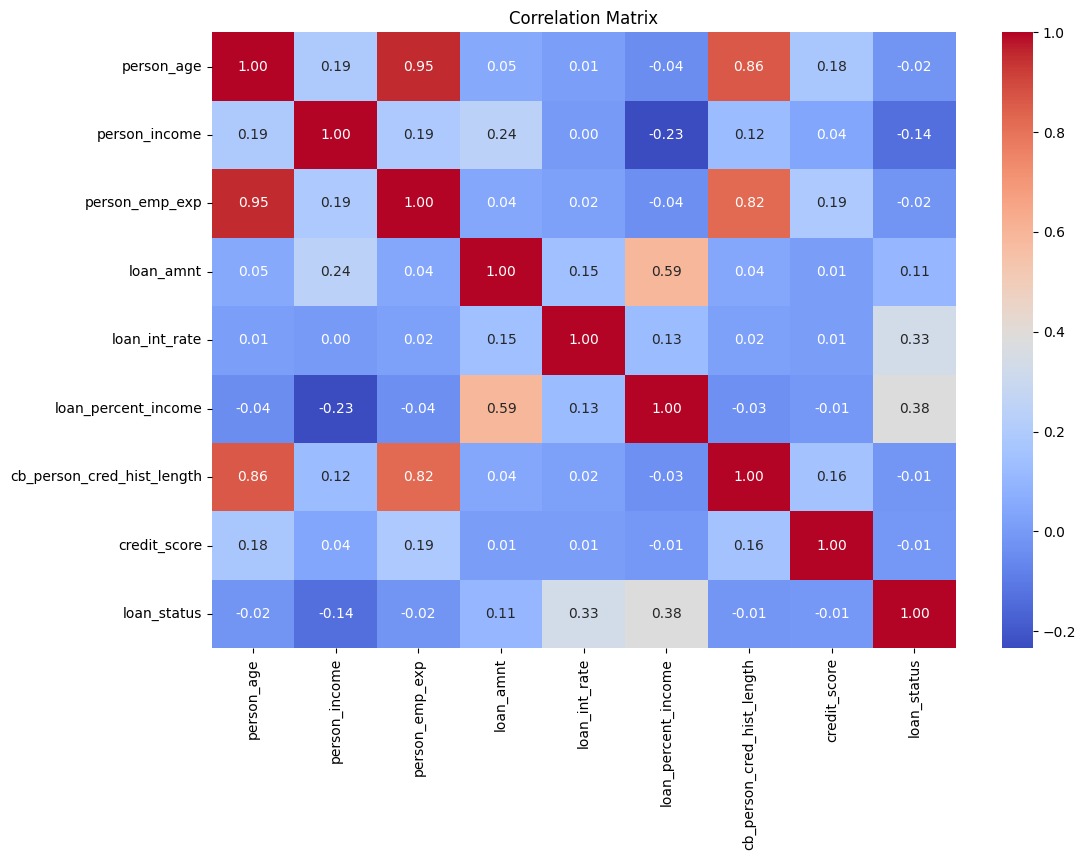

In [312]:
# Correlation matrix
plt.figure(figsize=(12, 8))
correlation_matrix = df.select_dtypes(include=['float64', 'int64']).corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


# Data Cleaning & Preprocessing

In [313]:
# Copy original df to df_cleaned
df_cleaned = df.copy()

In [314]:
# Remove unrealistic ages
original_row_count = df_cleaned.shape[0]
df_cleaned = df_cleaned[df_cleaned['person_age'] <= 125]
removed_count = original_row_count - df_cleaned.shape[0]


changelog.append({
    'column': 'age',
    'change': f'Removed {removed_count} row(s) where age > 125',
    'rationale': 'Oldest verified human lived to be 122; values above 125 are likely errors or outliers.',
})


In [315]:
# Drop loan_status column
df_cleaned.drop(columns=['loan_status'], inplace=True)
df_cleaned.reset_index(drop=True, inplace=True)
numerical_columns = df_cleaned.select_dtypes(include=[np.number]).columns.tolist()
changelog.append({
    'column': 'loan_status',
    'change': 'Dropped loan_status column',
    'rationale': 'Target variable for classification; not needed in cleaned dataset.',
})


Numerical columns after capping: ['person_age', 'person_income', 'person_emp_exp', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score']


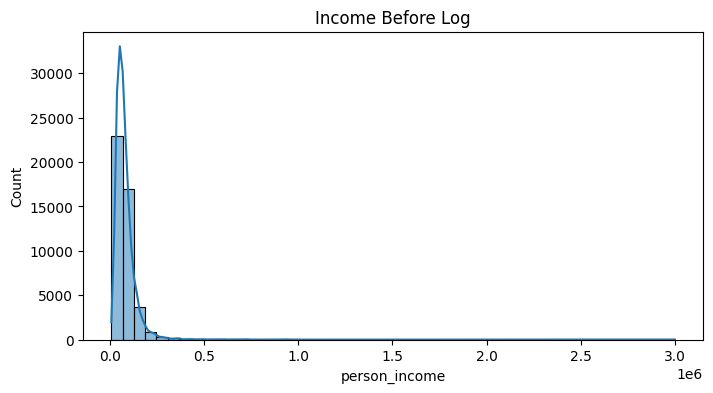

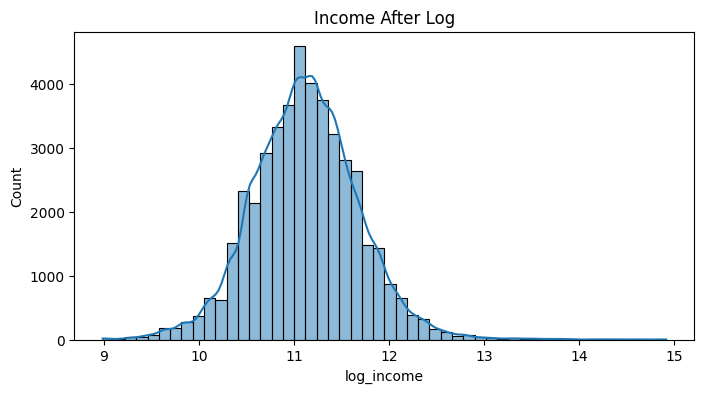

In [316]:
# Cap outliers before log-transform
df_cleaned['person_income'] = np.where(df_cleaned['person_income'] > 3_000_000, 3_000_000, df_cleaned['person_income'])


# Show numerical columns after capping
print("Numerical columns after capping:", numerical_columns)


# Apply log1p to preserve 0s and small values
df_cleaned['log_income'] = np.log1p(df_cleaned['person_income'])
changelog.append({
    'column': 'person_income',
    'change': 'Capped person_income at $3,000,000 and applied log1p transformation',
    'rationale': 'Handled extreme right skew and outliers in income distribution; log1p applied to normalize values and removed person_income for modeling.',
})


plt.figure(figsize=(8, 4))
sns.histplot(df_cleaned['person_income'], bins=50, kde=True)
plt.title("Income Before Log")
plt.show()

plt.figure(figsize=(8, 4))
sns.histplot(df_cleaned['log_income'], bins=50, kde=True)
plt.title("Income After Log")
plt.show()


In [317]:
# Drop person_income after log-transform
df_cleaned.drop(columns=['person_income'], inplace=True)
df_cleaned.reset_index(drop=True, inplace=True)
numerical_columns = df_cleaned.select_dtypes(include=[np.number]).columns.tolist()


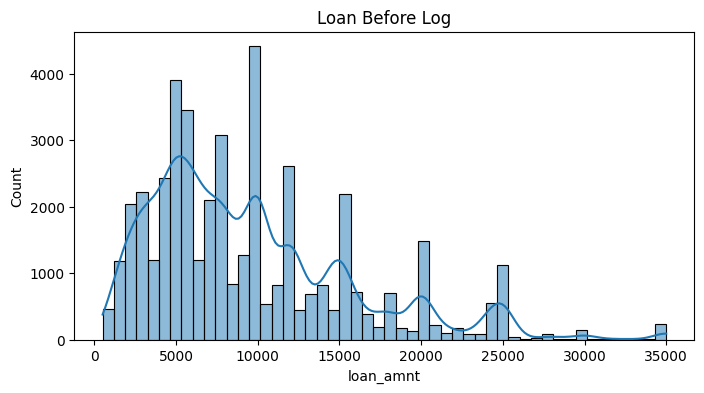

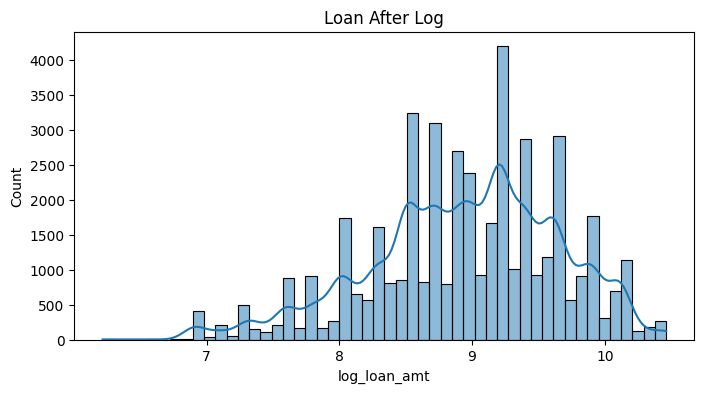

In [318]:
# Apply log1p to preserve 0s and small values
df_cleaned['log_loan_amt'] = np.log1p(df_cleaned['loan_amnt'])
changelog.append({
    'column': 'loan_amnt',
    'change': 'Applied log1p transformation to loan_amount',
    'rationale': 'Handled extreme right skew and outliers in loan amount distribution; log1p applied to normalize values.',
})

plt.figure(figsize=(8, 4))
sns.histplot(df_cleaned['loan_amnt'], bins=50, kde=True)
plt.title("Loan Before Log")
plt.show()

plt.figure(figsize=(8, 4))
sns.histplot(df_cleaned['log_loan_amt'], bins=50, kde=True)
plt.title("Loan After Log")
plt.show()

In [319]:
# Drop loan_amnt after log-transform
df_cleaned.drop(columns=['loan_amnt'], inplace=True)
df_cleaned.reset_index(drop=True, inplace=True)
numerical_columns = df_cleaned.select_dtypes(include=[np.number]).columns.tolist()

In [320]:
# Remove unrealistic person_emp_exp values
original_row_count = df_cleaned.shape[0]
df_cleaned = df_cleaned[df_cleaned['person_emp_exp'] <= 70]
removed_count = original_row_count - df_cleaned.shape[0]
changelog.append({
    'column': 'person_emp_exp',
    'change': f'Removed {removed_count} row(s) where person_emp_exp > 70',
    'rationale': 'Unrealistic employment experience; values above 70 years are likely errors or outliers.',
}) 

In [321]:
# Scale numerical columns using MinMaxScaler
minmax_scaler = MinMaxScaler()
df_cleaned[numerical_columns] = minmax_scaler.fit_transform(df_cleaned[numerical_columns])
df_cleaned.head()


# Changelog for scaling
changelog.append({
    'column': 'numerical_columns',
    'change': 'Scaled numerical columns using MinMaxScaler',
    'rationale': 'Normalized numerical features to a range of [0, 1] for better model performance.',
})


<class 'pandas.core.frame.DataFrame'>
Index: 44992 entries, 0 to 44996
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      44992 non-null  float64
 1   person_gender                   44992 non-null  object 
 2   person_education                44992 non-null  object 
 3   person_emp_exp                  44992 non-null  float64
 4   person_home_ownership           44992 non-null  object 
 5   loan_intent                     44992 non-null  object 
 6   loan_int_rate                   44992 non-null  float64
 7   loan_percent_income             44992 non-null  float64
 8   cb_person_cred_hist_length      44992 non-null  float64
 9   credit_score                    44992 non-null  float64
 10  previous_loan_defaults_on_file  44992 non-null  object 
 11  log_income                      44992 non-null  float64
 12  log_loan_amt                    44992

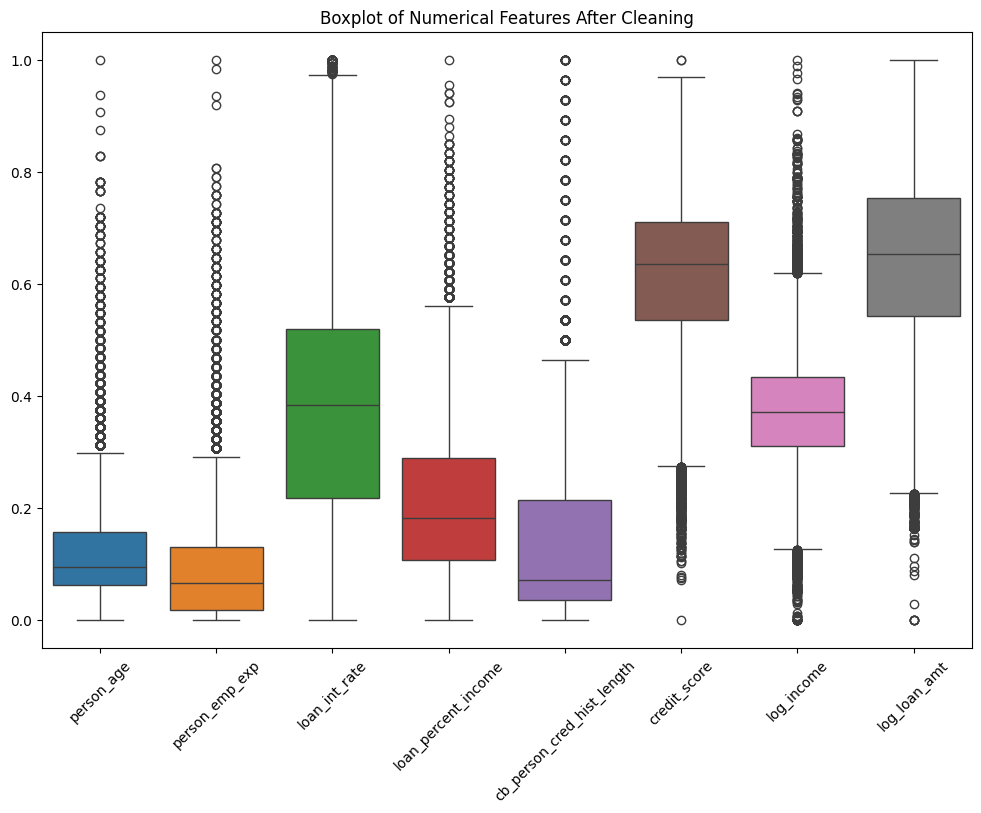

In [322]:
# Check cleaned data
df_cleaned.info()
df_cleaned.describe()

# Plot boxplot for cleaned data
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_cleaned[numerical_columns])
plt.title('Boxplot of Numerical Features After Cleaning')
plt.xticks(rotation=45)
plt.show()

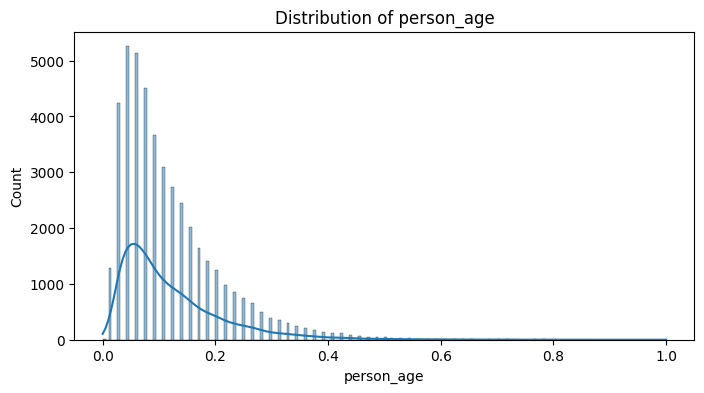

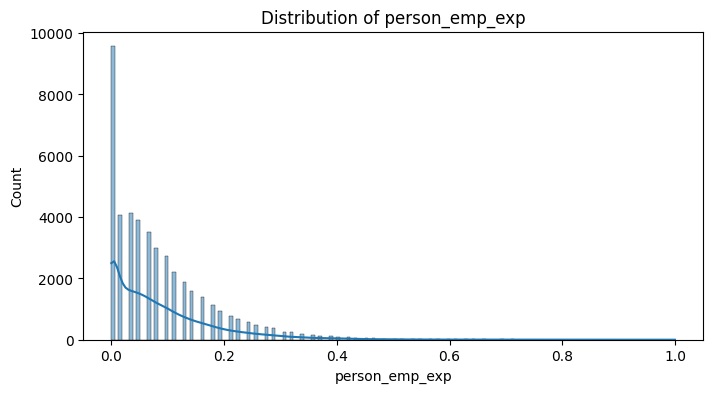

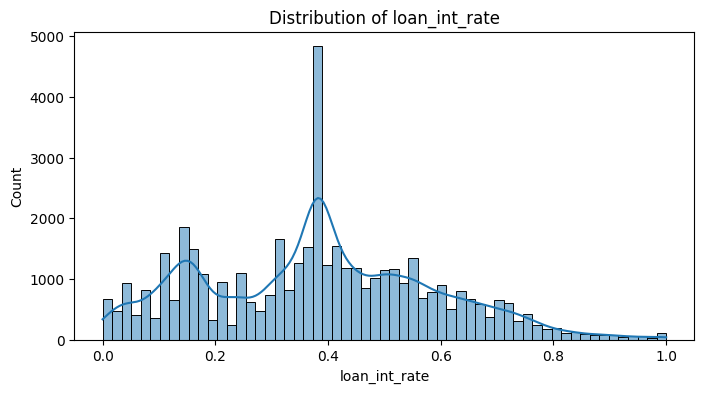

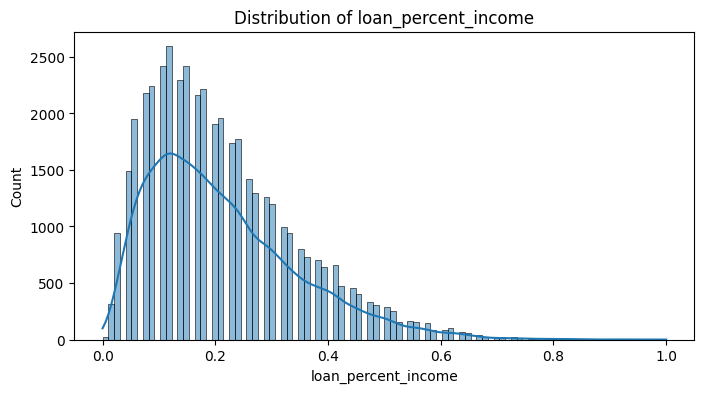

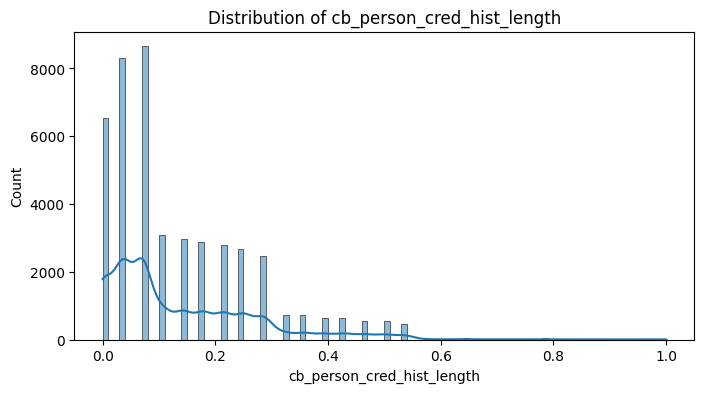

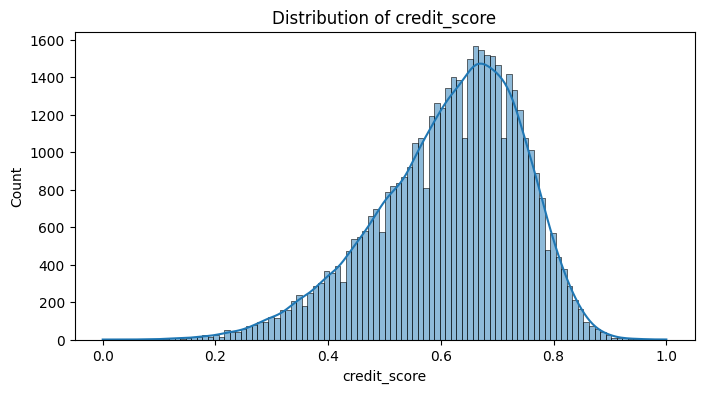

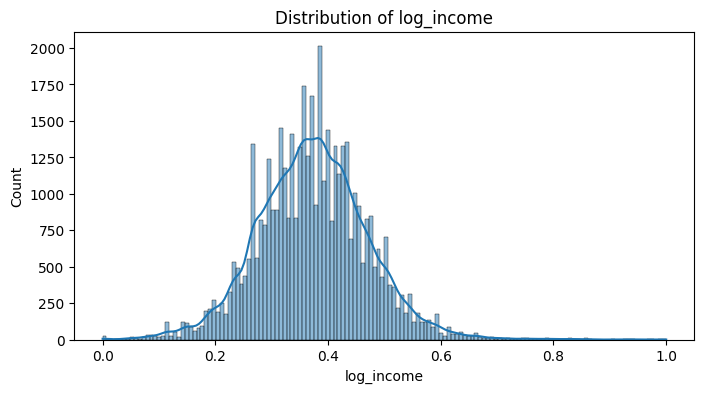

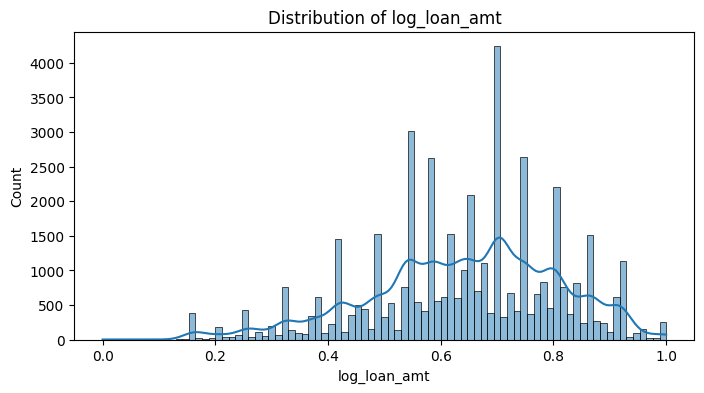

In [324]:
for col in numerical_columns:
    fig = plt.figure(figsize=(8, 4))
    sns.histplot(df_cleaned[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()


In [325]:
# Change summary intialization and check
change_summary = pd.DataFrame(changelog)
pd.set_option('display.max_colwidth', None)
display(change_summary)  

,column,change,rationale
0,age,Removed 3 row(s) where age > 125,Oldest verified human lived to be 122; values above 125 are likely errors or outliers.
1,loan_status,Dropped loan_status column,Target variable for classification; not needed in cleaned dataset.
2,person_income,"Capped person_income at $3,000,000 and applied log1p transformation",Handled extreme right skew and outliers in income distribution; log1p applied to normalize values and removed person_income for modeling.
3,loan_amnt,Applied log1p transformation to loan_amount,Handled extreme right skew and outliers in loan amount distribution; log1p applied to normalize values.
4,person_emp_exp,Removed 5 row(s) where person_emp_exp > 70,Unrealistic employment experience; values above 70 years are likely errors or outliers.
5,numerical_columns,Scaled numerical columns using MinMaxScaler,"Normalized numerical features to a range of [0, 1] for better model performance."


<class 'pandas.core.frame.DataFrame'>
Index: 44992 entries, 0 to 44996
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      44992 non-null  float64
 1   person_gender                   44992 non-null  object 
 2   person_education                44992 non-null  object 
 3   person_emp_exp                  44992 non-null  float64
 4   person_home_ownership           44992 non-null  object 
 5   loan_intent                     44992 non-null  object 
 6   loan_int_rate                   44992 non-null  float64
 7   loan_percent_income             44992 non-null  float64
 8   cb_person_cred_hist_length      44992 non-null  float64
 9   credit_score                    44992 non-null  float64
 10  previous_loan_defaults_on_file  44992 non-null  object 
 11  log_income                      44992 non-null  float64
 12  log_loan_amt                    44992

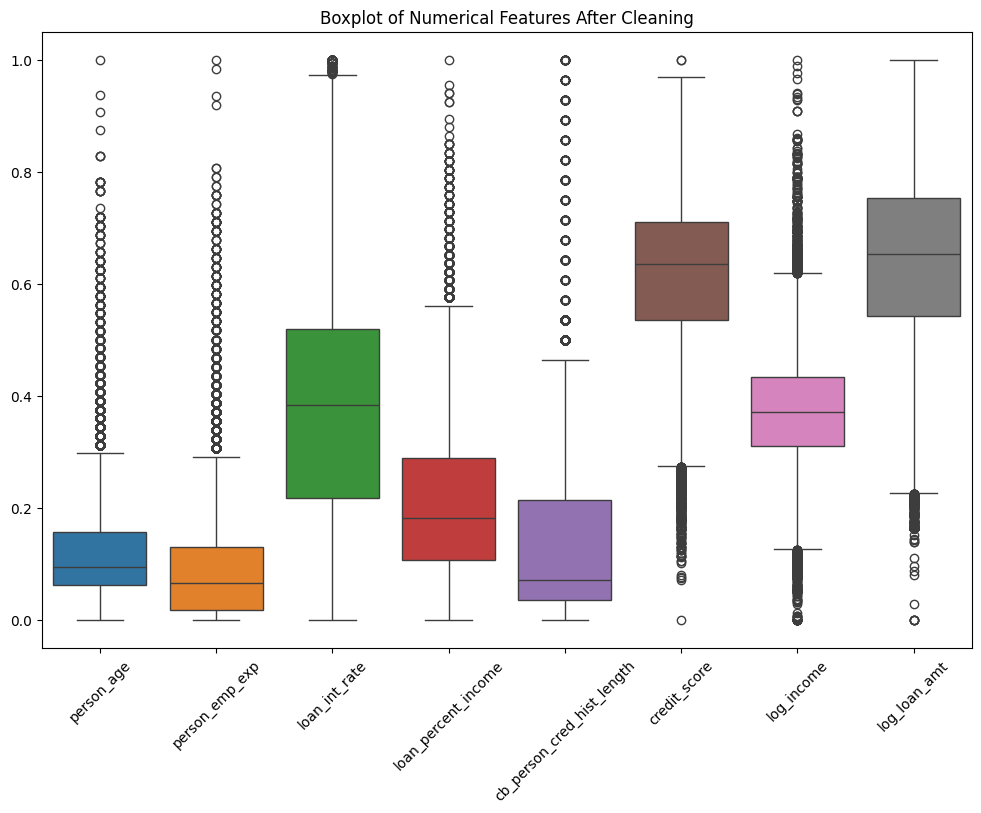

In [326]:
# Check cleaned data
df_cleaned.info()
df_cleaned.describe()

# Plot boxplot for cleaned data
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_cleaned[numerical_columns])
plt.title('Boxplot of Numerical Features After Cleaning')
plt.xticks(rotation=45)
plt.show()